# Demo For Logistic Hybrid Payoff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
from utils import create_reward_plot, plot_regret, create_result_dict, plot_action_freq
import matplotlib.pyplot as plt
from algorithms.logistic import DisEcoLog, HyEcoLog
from environment import HybridBandits

In [2]:
# Function to run 1 trial
def simulate(env, algo_arr, T):
    d = {}
    nr = 5
    for algo in algo_arr:
        if algo.name.startswith('DisEcoLog'):
            d['DisEcoLog'] = []
        elif algo.name.startswith('HyEcoLog'):
            d['HyEcoLog'] = []
    con_act_ls = [deepcopy(d) for _ in range(env.num_context)]
    for t in tqdm(range(T)):
        t = t % T
        a_t = []
        context_id = env.context_seq[env.t]
        for algo in algo_arr:
            a = algo.next_action()
            if algo.name.startswith('DisEcoLog'):
                con_act_ls[context_id]['DisEcoLog'].append(a)
            elif algo.name.startswith('HyEcoLog'):
                con_act_ls[context_id]['HyEcoLog'].append(a)
            a_t.append(a)
        rewards_t, regrets_t, action_set_t = env.step(a_t)
        for i, algo in enumerate(algo_arr):
            algo.update(rewards_t[i], regrets_t[i], action_set_t)
    #plot_action_freq(con_act_ls, env, nrows=nr, ncols=env.num_context // nr)
    return con_act_ls

In [3]:
def multi_simulation(num_trials, algo_dict, env:HybridBandits, delta:float, T:int):
    all_rewards = [np.zeros((num_trials, T)) for _ in range(len(algo_dict.keys()))]
    all_regrets = [np.zeros((num_trials, T)) for _ in range(len(algo_dict.keys()))]
    for i in range(num_trials):
        algo_arr = []
        for k in algo_dict.keys():
            if k == 'DisEcoLog':
                lmbda = algo_dict[k]['lambda']
                algo_arr.append(DisEcoLog(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, lmbda, env.kappa))
            elif k == 'HyEcoLog':
                lmbda = algo_dict[k]['lambda']
                algo_arr.append(HyEcoLog(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, lmbda, env.kappa))
        print('Simulating Trial', i+1)
        ls = simulate(env, algo_arr, T)
        env.reset()
        for j in range(len(algo_arr)):
            all_rewards[j][i] += np.array(algo_arr[j].rewards)
            all_regrets[j][i] += np.array(algo_arr[j].regrets)
    return all_rewards, all_regrets, ls

In [4]:
# Define Environment Configuration

config = {}
config['seed'] = 984397                 #np.random.randint(1098321) # Uncomment the random seed generator for random instances
print('Seed:', config['seed'])
config['model_type'] = 'Logistic'
config['horizon_length'] = 3000       # Number of time steps T
config['num_labels'] = 10               # Number of actions L
config['num_context'] = 20              # Context set size
config['theta_dim'] = 5                 # Dimension of theta d
config['beta_dim'] = 2                  # Dimension of beta k
config['theta_norm'] = 5.0              # Max norm of theta M
config['beta_norm'] = 2.0               # Max norm of beta_i's N
config['x_norm'] = 0.4                  # Max norm of x
config['z_norm'] = 0.4                  # Max norm of z
config['subgaussian'] = 0.01             # Subgaussianity of noise
config['arm_desc'] = None                # Description for the set of arms that environment generates -- 'easy': large suboptimality gap, 'proportional': z_i = 0.3 * x_i
env_name = 'Testbench'                  # Name of the simulation

Seed: 984397


In [5]:
env = HybridBandits(name=env_name, config=config)

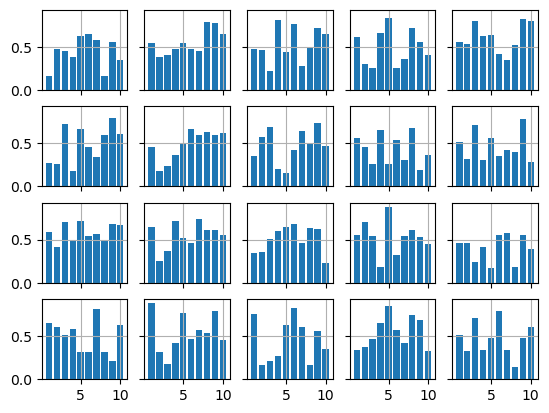

In [6]:
create_reward_plot(env, 4, 5)

In [7]:
# Add the algorithms to test and their hyperparameters
#algo_dict = {'DisEcoLog': {'lambda': 1.0}}
algo_dict = {'HyEcoLog': {'lambda': 1.0},
             'DisEcoLog': {'lambda': 1.0}}
delta = 0.05 # High probability guarantee

In [8]:
num_trials = 1  # Number of trials
T = env.T
print('kappa =', env.kappa)
env.reset()

kappa = 9.854883589258998
[ 0.96435805  3.15921847  0.4504067  -3.69308805  0.49758083]


Simulating Trial 1


  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [02:16<00:00, 21.99it/s]


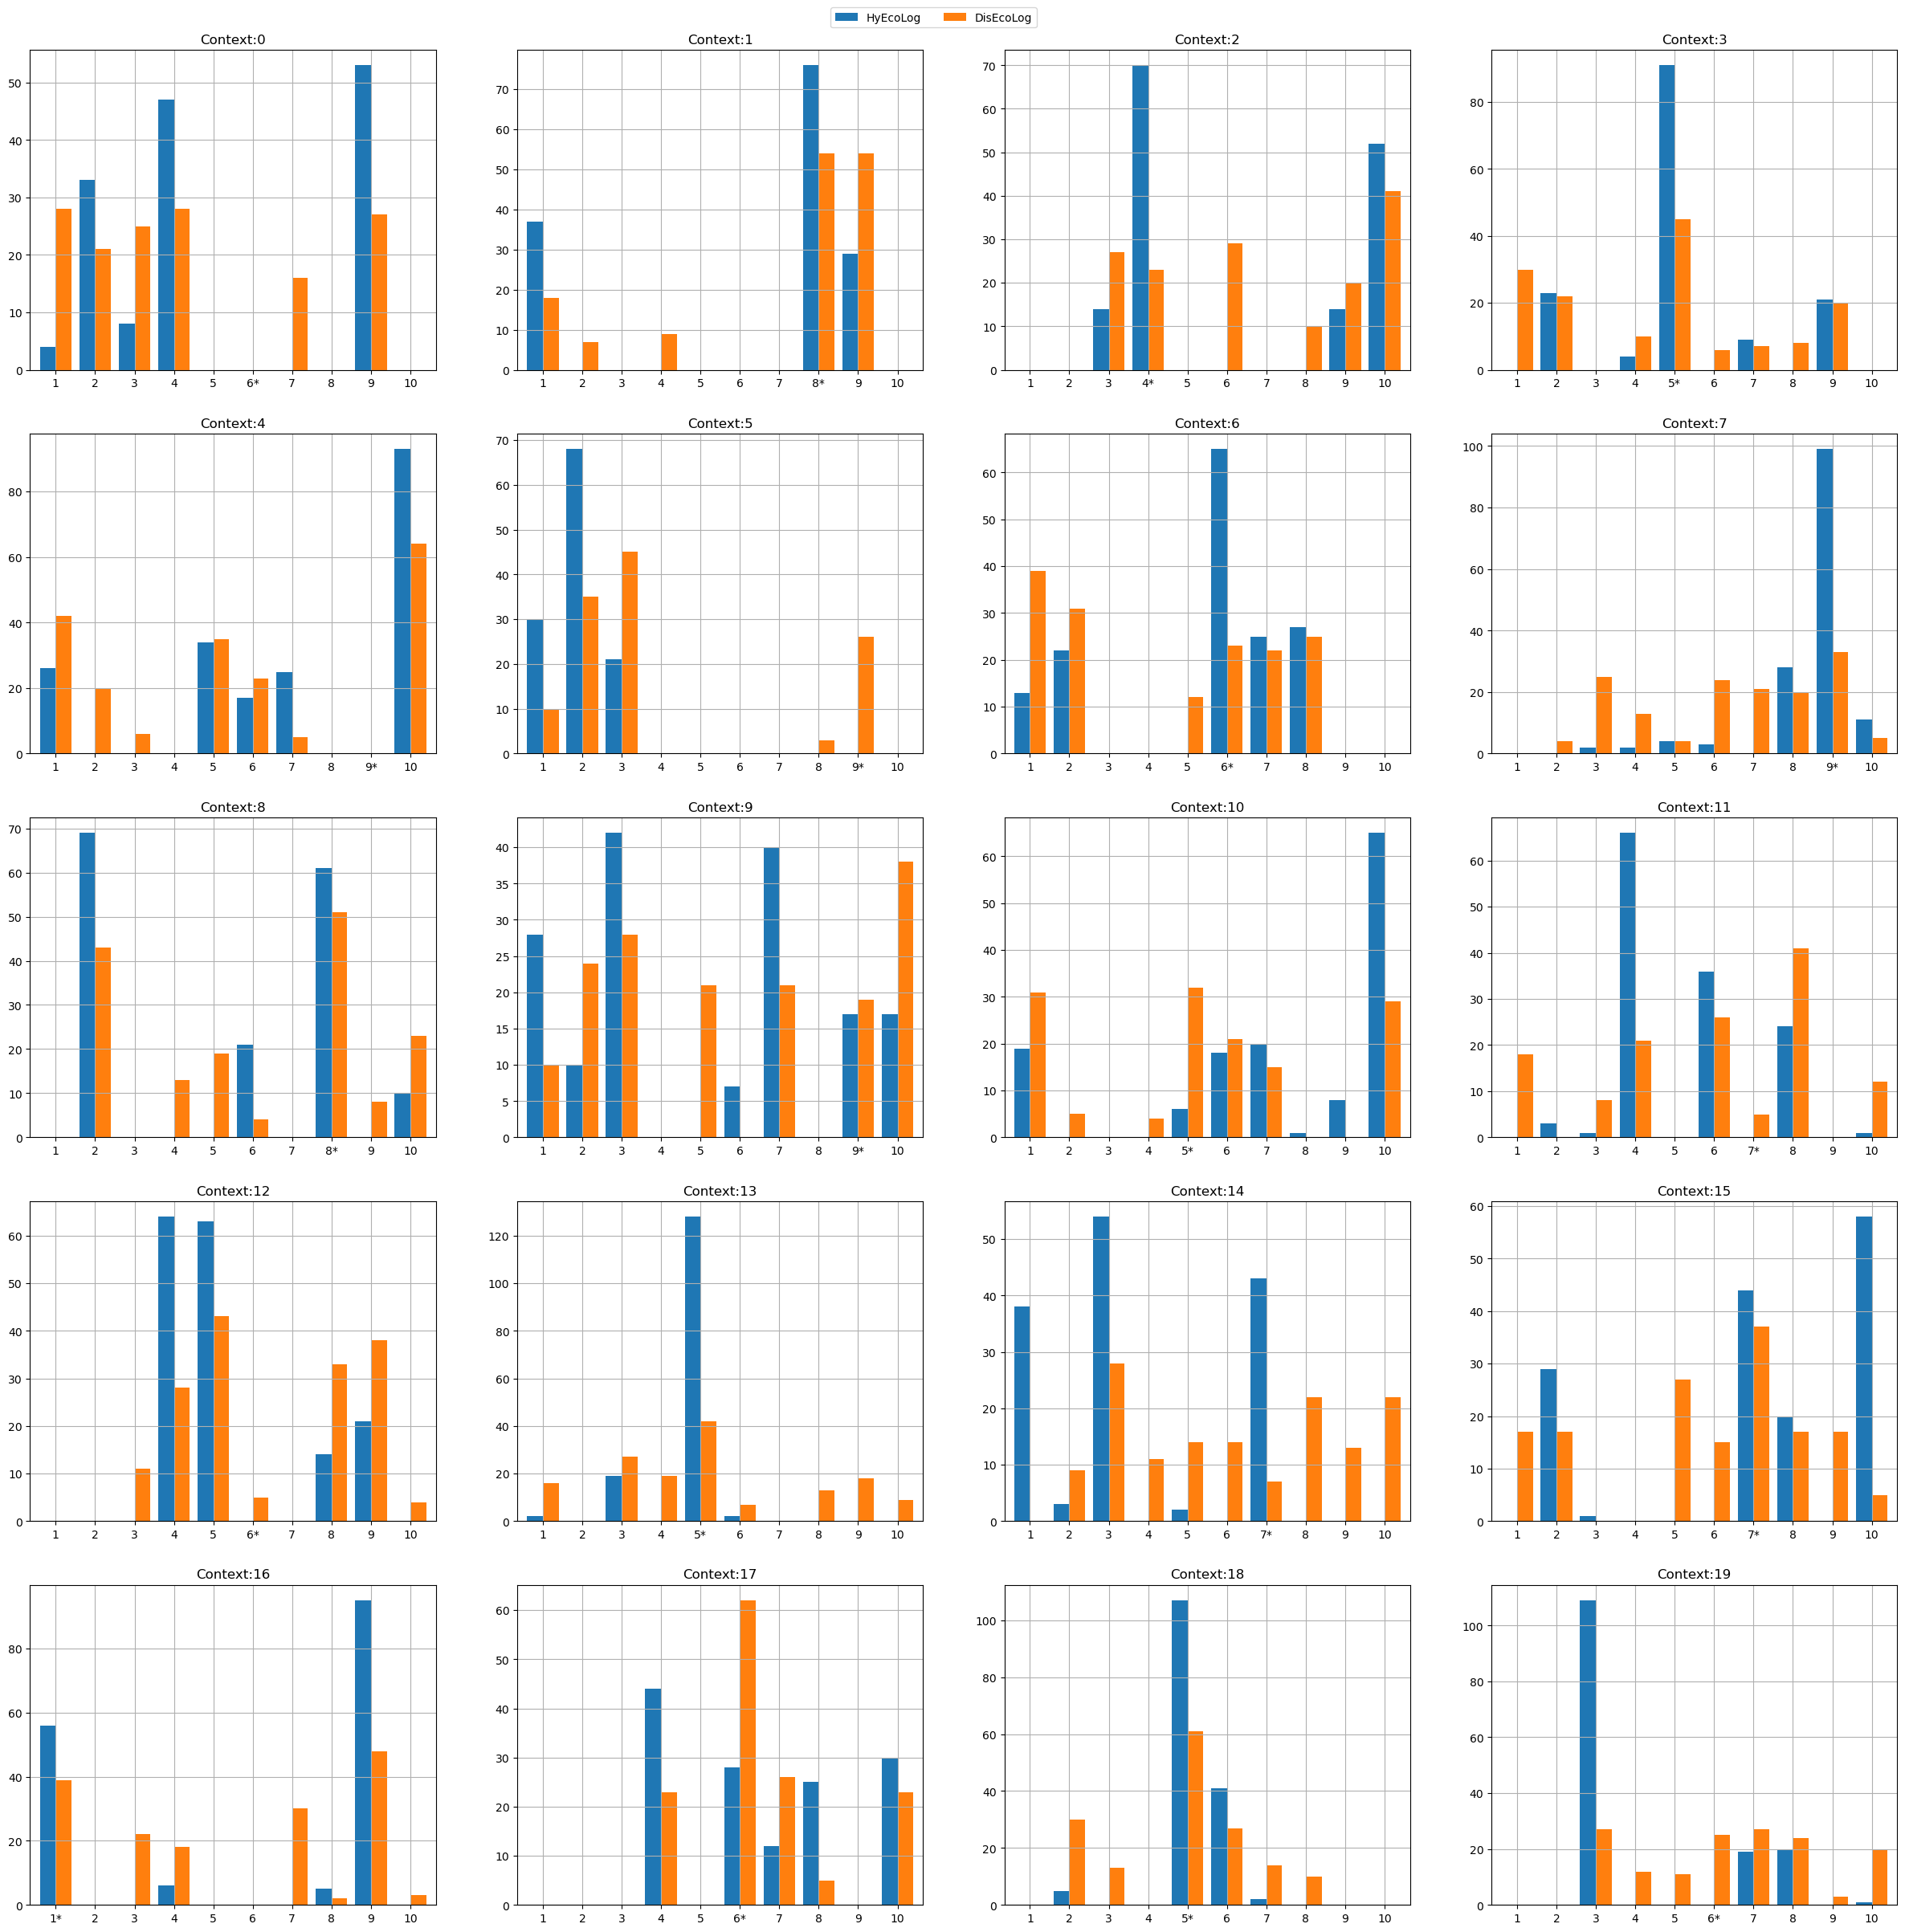

[ 0.54893184  3.05844684  0.05347866 -2.83471715  0.45571957  1.98806602
 -1.00290274  1.59569473  2.21959046 -0.35560143  1.31322249 -0.8784284
 -1.31661642 -2.36465919 -1.40595997  0.33176579 -1.4503875  -1.35341882
 -1.21831126 -0.72608115  1.50796395  1.77621856 -1.94134152  1.01536476
 -2.61869251]


In [9]:
rewards, regrets, ls = multi_simulation(num_trials, algo_dict, env, delta, T)
result_dict = create_result_dict(rewards, regrets, algo_dict, T)

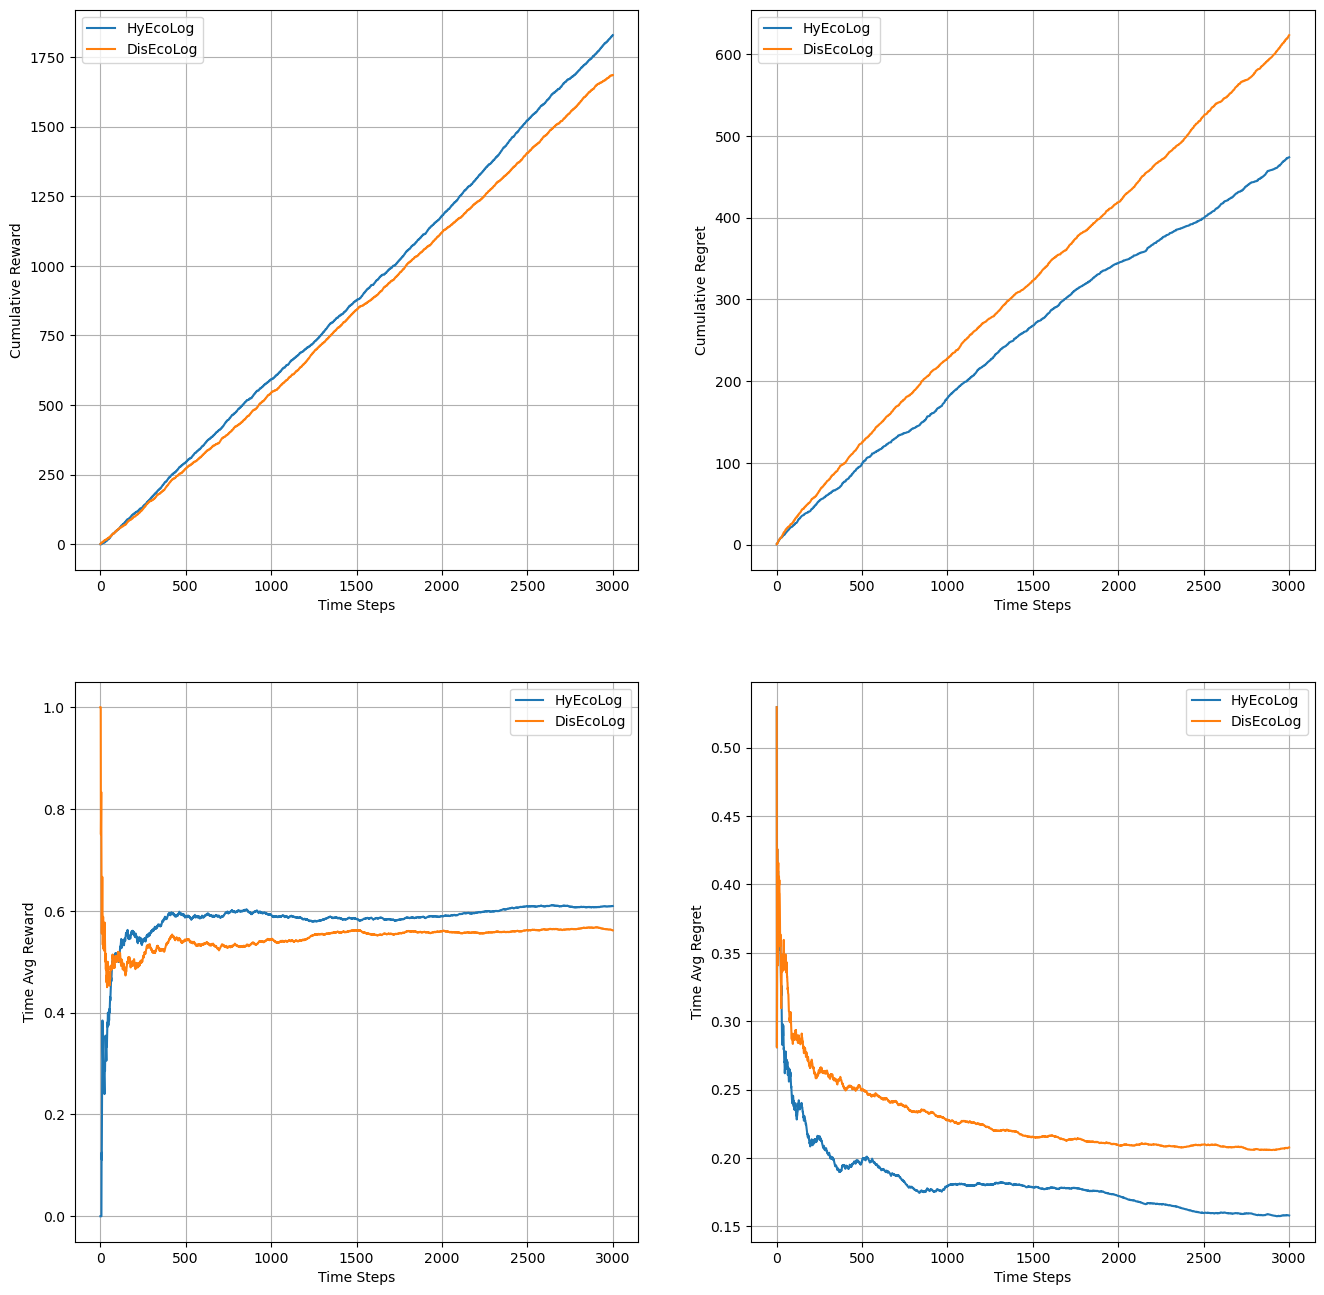

In [10]:
plot_regret(result_dict, env.T)